<a href="https://colab.research.google.com/github/sara-iqbal/Agentic-Credit-Risk-Engine/blob/main/End_to_End_Agentic_Credit_Risk_Scoring_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Agentic Credit Risk Scoring Engine

Author: Sara Iqbal, Shreenidhi Kovai Sivabalan

Domain: Quantitative Finance | Machine Learning | Agentic AI

Tech Stack: Python, Scikit-Learn, Streamlit, LangChain, Groq (Llama-3), SHAP

This project builds a regulatory-compliant Credit Scoring System (Basel III aligned) that predicts the Probability of Default (PD) for loan applicants. Unlike traditional "black box" models, this engine uses Weight of Evidence (WoE) transformation and Logistic Regression to ensure full interpretability.


Beyond prediction, the system is operationalized into a Full-Stack Banking App featuring:

1.Risk-Based Pricing: Dynamically calculating interest rates (APR) based on risk tiers

2.Macro-Economic Stress Testing: Simulating recession scenarios (IFRS 9) to .forecast capital loss.

3.Agentic AI: A "Human-in-the-Loop" AI Agent (Llama-3) that provides plain-English explanations for every decision.

4.MLOps: Automated concept drift detection to monitor model health in real-time.

Step 1: Data Ingestion & Preprocessing

In this section, we ingest the raw German Credit dataset from the UCI repository and assign meaningful column headers to structure the data. A key preprocessing step involves re-mapping the target variable to a standard binary classification format, where '1' represents a Default (Bad) and '0' represents a Non-Default (Good), allowing the model to explicitly predict default probability. Finally, the cleaned dataframe is verified for structural integrity and exported as a CSV file to serve as the stable foundation for our subsequent feature engineering and modeling pipeline.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the data
# We are fetching the data directly from the UCI Machine Learning Repository.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

# The original dataset doesn't have column names, so we define them manually.
column_names = [
    'checking_account', 'duration_months', 'credit_history', 'purpose',
    'credit_amount', 'savings_account', 'employment_length', 'installment_rate',
    'personal_status', 'other_debtors', 'residence_since', 'property',
    'age', 'other_installment_plans', 'housing', 'existing_credits',
    'job', 'people_liable', 'telephone', 'foreign_worker', 'target'
]

# Load the data (it uses spaces as separators)
df = pd.read_csv(url, sep=' ', names=column_names)

print(f"Data Loaded! Shape: {df.shape} (Rows, Columns)")

# Fixing the target variables
# original data: 1 = Good, 2 = Bad
# rule of thumb: 0 = Good, 1 = Bad (Default)
# We need to map 2 to 1, and 1 to 0.

df['target'] = df['target'].map({1: 0, 2: 1})

# Checking if it worked
print("\n Target Variable Distribution:")
print(df['target'].value_counts(normalize=True))

# Health Check of the data
# Let's peek at the first 5 rows to ensure headers are correct
print("\n First 5 Rows:")
display(df.head())

# Save this cleaned version
df.to_csv("german_credit_cleaned.csv", index=False)
print("\n File saved as 'german_credit_cleaned.csv'. Ready for Day 2!")

Data Loaded! Shape: (1000, 21) (Rows, Columns)

 Target Variable Distribution:
target
0    0.7
1    0.3
Name: proportion, dtype: float64

 First 5 Rows:


,checking_account,duration_months,credit_history,purpose,credit_amount,savings_account,employment_length,installment_rate,personal_status,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1



 File saved as 'german_credit_cleaned.csv'. Ready for Day 2!


Step 2: Exploratory Data Analysis (EDA) & Risk Visualization

 The dataset to uncover key risk drivers and structural patterns. We begin by plotting the Target Distribution to assess class imbalance (70% Good vs. 30% Bad), which is crucial for determining our model validation strategy. We then implement a custom function, plot_risk_rate, to examine the relationship between categorical features—such as checking_account—and default probability, ensuring the data exhibits logical, monotonic risk trends. Finally, we generate a Correlation Matrix heatmap for numerical variables to detect potential multicollinearity, ensuring our input features are independent and suitable for logistic regression.

/tmp/ipython-input-610630470.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=df, palette='coolwarm')


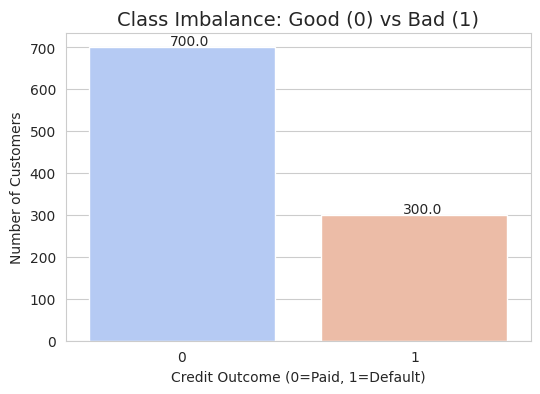

target
0    70.0
1    30.0
Name: proportion, dtype: float64


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the visual style
sns.set_style("whitegrid")

# Target Distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='target', data=df, palette='coolwarm')
plt.title('Class Imbalance: Good (0) vs Bad (1)', fontsize=14)
plt.xlabel('Credit Outcome (0=Paid, 1=Default)')
plt.ylabel('Number of Customers')

# Add labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 5))
plt.show()

# Print exact percentages
print(df['target'].value_counts(normalize=True) * 100)

/tmp/ipython-input-4012794736.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_rate.index, y=risk_rate.values, palette="Reds")


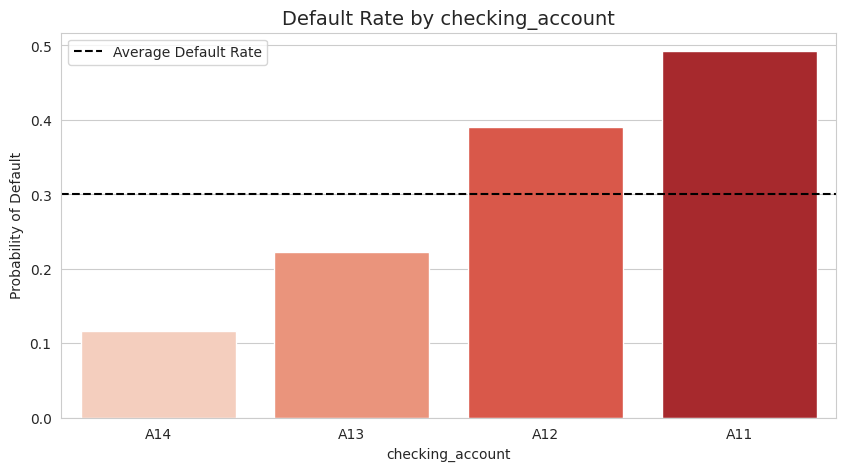

In [3]:
# Function to plot Risk Rate
def plot_risk_rate(df, column):
    # Calculate average default rate per category
    risk_rate = df.groupby(column)['target'].mean().sort_values()

    plt.figure(figsize=(10, 5))
    sns.barplot(x=risk_rate.index, y=risk_rate.values, palette="Reds")
    plt.title(f'Default Rate by {column}', fontsize=14)
    plt.ylabel('Probability of Default')
    plt.axhline(y=df['target'].mean(), color='k', linestyle='--', label='Average Default Rate')
    plt.legend()
    plt.show()

# Let's check the #1 Predictor: Checking Account
plot_risk_rate(df, 'checking_account')

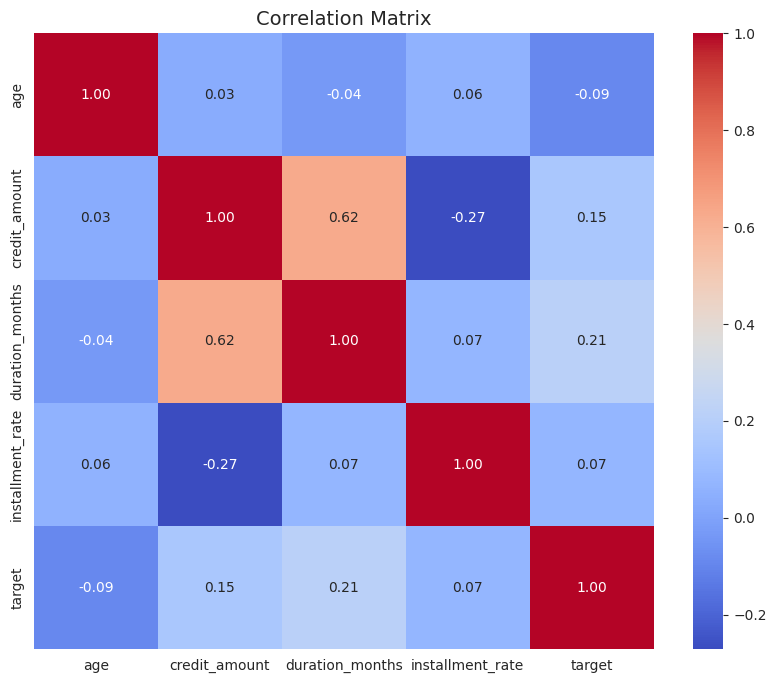

In [4]:
# Select only numerical columns
num_cols = ['age', 'credit_amount', 'duration_months', 'installment_rate', 'target']

plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Feature Engineering with Weight of Evidence (WoE)

In this critical step, we define the calculate_woe_iv function, a core component of credit scorecard modeling. This function transforms categorical and continuous variables into a standardized Weight of Evidence (WoE) scale, which linearizes the relationship between independent variables and the log-odds of the target (default). It handles potential mathematical errors (division by zero) and computes the Information Value (IV) to quantify the predictive power of each feature. We demonstrate this by binning the numerical variable duration_months into 5 quantiles (qcut) and calculating its WoE and IV. The resulting plot visualizes the linearity of the transformed feature, confirming its suitability for Logistic Regression.

In [5]:
# 1. Defining the WOE Function
def calculate_woe_iv(df, feature, target):
    """
    Takes a dataframe, a specific feature (column), and the target column.
    Returns:
    1. A DataFrame showing the WoE for each group.
    2. The total Information Value (IV) for that feature.
    """
    # Group by the feature and count totals
    lst = []
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]

        # Count statistics
        all_count = df[df[feature] == val].count()[feature]
        good_count = df[(df[feature] == val) & (df[target] == 0)].count()[feature]
        bad_count = df[(df[feature] == val) & (df[target] == 1)].count()[feature]

        lst.append({
            'Value': val,
            'All': all_count,
            'Good': good_count,
            'Bad': bad_count
        })

    dset = pd.DataFrame(lst)

    # Handle Division by Zero (Safety check)
    # If a bin has 0 goods or 0 bads, we add a tiny number (0.5) so the math doesn't break
    dset = dset.replace({'Good': {0: 0.5}, 'Bad': {0: 0.5}})

    # Calculate Distributions
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()

    # Calculate WoE (The Natural Log)
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])

    # Calculate IV
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']

    # Sort by WoE to check for linearity (Monotonicity)
    dset = dset.sort_values(by='WoE')

    return dset, dset['IV'].sum()

print(" WoE Function defined successfully!")

 WoE Function defined successfully!


Information Value (IV) for Checking Account: 0.6660

Look at how the 'Values' (A11, A12) are now sorted by Risk (WoE):


,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV
0,A11,274,139,135,0.198571,0.450000,-0.818099,0.205693
1,A12,269,164,105,0.234286,0.350000,-0.401392,0.046447
3,A13,63,49,14,0.070000,0.046667,0.405465,0.009461
2,A14,394,348,46,0.497143,0.153333,1.176263,0.404410


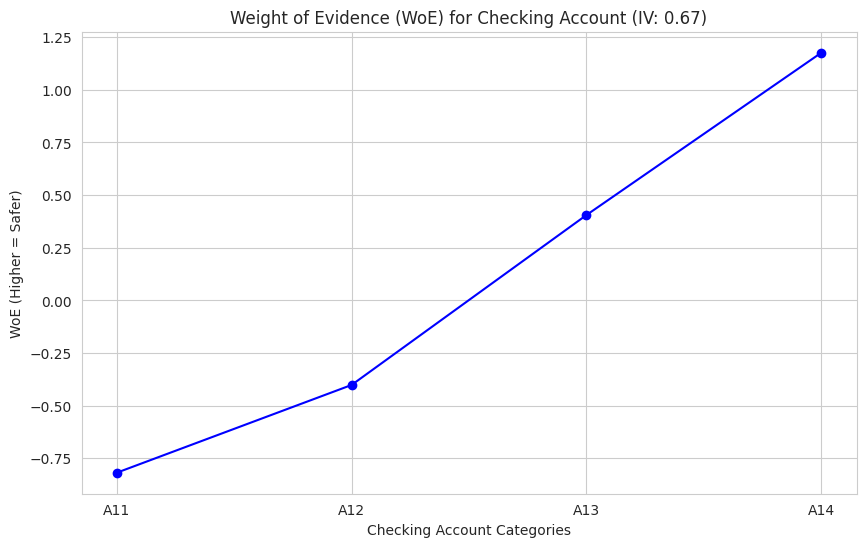

In [6]:
# 2. Test on Checking Account

# Calculate WoE
df_woe_checking, iv_checking = calculate_woe_iv(df, 'checking_account', 'target')

# Display the Result
print(f"Information Value (IV) for Checking Account: {iv_checking:.4f}")
print("\nLook at how the 'Values' (A11, A12) are now sorted by Risk (WoE):")
display(df_woe_checking)

# 3. Visualising It
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_woe_checking['Value'], df_woe_checking['WoE'], marker='o', linestyle='-', color='blue')
plt.title(f'Weight of Evidence (WoE) for Checking Account (IV: {iv_checking:.2f})')
plt.xlabel('Checking Account Categories')
plt.ylabel('WoE (Higher = Safer)')
plt.grid(True)
plt.show()

IV for Loan Duration: 0.2162


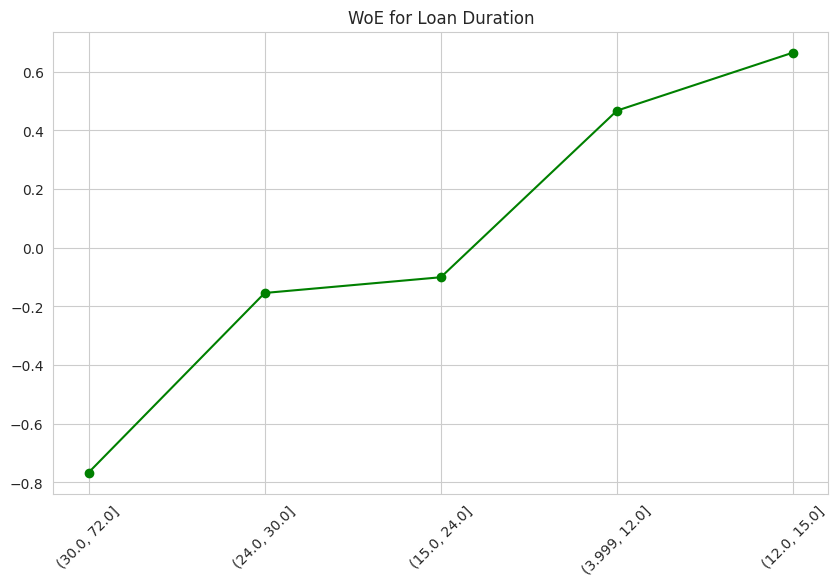

In [7]:
# Handling the Numerical Variables by Binning

# 1. Create a new column 'duration_bins' by cutting the data into 5 equal chunks
df['duration_bins'] = pd.qcut(df['duration_months'], q=5)

# 2. Now calculate WoE on the BINS
df_woe_duration, iv_duration = calculate_woe_iv(df, 'duration_bins', 'target')

print(f"IV for Loan Duration: {iv_duration:.4f}")


# Plotting it
plt.figure(figsize=(10, 6))
# Convert intervals to string so they plot easily
df_woe_duration['Value'] = df_woe_duration['Value'].astype(str)
plt.plot(df_woe_duration['Value'], df_woe_duration['WoE'], marker='o', color='green')
plt.title('WoE for Loan Duration')
plt.xticks(rotation=45)
plt.show()

 Variable Selection & Binning Strategy

 The WoE transformation across the entire dataset. First, we segregate variables into numerical and categorical types, applying quantile binning (qcut) to numerical features (e.g., credit_amount, age) to handle non-linearities and outliers. We then iterate through all candidate features, calculating their Information Value (IV) and storing their specific WoE mappings in a dictionary (woe_maps) for later model implementation. A summary dataframe ranks features by predictive power (IV), visualized with thresholds (IV < 0.02 is weak, IV > 0.5 is suspicious), ensuring we only select robust predictors for the final model.

Calculating WoE for all variables... Please wait.

 Feature Importance Report (IV):


,Feature,IV
0,checking_account,0.666012
1,credit_history,0.293234
15,duration_months_bins,0.216183
3,savings_account,0.196010
2,purpose,0.169195
7,property,0.112638
13,credit_amount_bins,0.093362
4,employment_length,0.086434
9,housing,0.083293
14,age_bins,0.068370


/tmp/ipython-input-1514574335.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='IV', y='Feature', data=df_iv, palette='viridis')


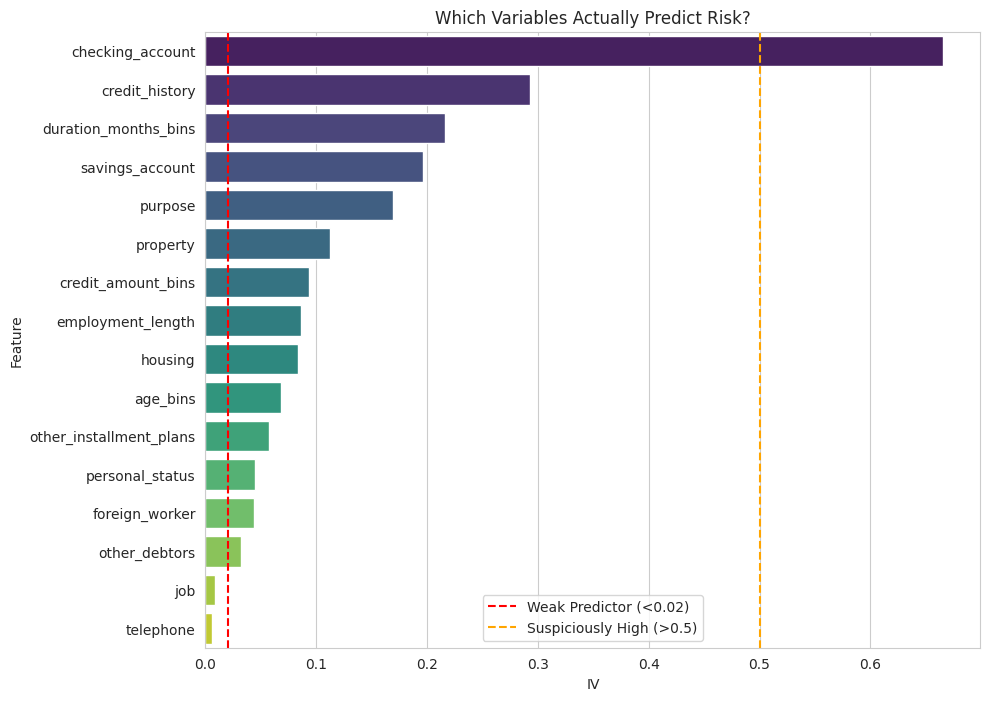

In [8]:
# 1. Defining which varibales to use

# We separate them because numericals need binning first
num_cols = ['credit_amount', 'age', 'duration_months']
cat_cols = ['checking_account', 'credit_history', 'purpose', 'savings_account',
            'employment_length', 'personal_status', 'other_debtors',
            'property', 'other_installment_plans', 'housing', 'job',
            'telephone', 'foreign_worker']

# 2. Binning the Numerical Variables
# We use 'qcut' to split them into 5 equal parts (quantiles)
for col in num_cols:
    # We add '_bins' to the name so we don't overwrite the original
    df[col + '_bins'] = pd.qcut(df[col], q=5, duplicates='drop')

# Now we have a final list of columns to analyze (Categorical + Binned Numericals)
final_cols = cat_cols + [col + '_bins' for col in num_cols]

# 3. Calculating IV for everything
iv_summary = []
woe_maps = {} # We will save the mappings here to use later

print("Calculating WoE for all variables... Please wait.")

for col in final_cols:
    # Run our magic function
    df_woe, iv = calculate_woe_iv(df, col, 'target')

    # Save the IV to our summary list
    iv_summary.append({'Feature': col, 'IV': iv})

    # Save the WoE values to a dictionary (We need this to replace values later!)
    # Create a simple mapping: { 'A11': -0.5, 'A12': 0.8 }
    woe_maps[col] = pd.Series(df_woe.WoE.values, index=df_woe.Value).to_dict()

# 4. Show the Ranking
df_iv = pd.DataFrame(iv_summary).sort_values(by='IV', ascending=False)

print("\n Feature Importance Report (IV):")
display(df_iv)

# Visualisation of the "Cut-Off"
plt.figure(figsize=(10, 8))
sns.barplot(x='IV', y='Feature', data=df_iv, palette='viridis')
plt.axvline(x=0.02, color='r', linestyle='--', label='Weak Predictor (<0.02)')
plt.axvline(x=0.5, color='orange', linestyle='--', label='Suspiciously High (>0.5)')
plt.title('Which Variables Actually Predict Risk?')
plt.legend()
plt.show()

WoE Transformation & Feature Selection

In this final preprocessing stage, we execute feature selection by filtering for variables with an Information Value (IV) greater than 0.02, effectively discarding weak predictors. We then construct the training dataset by mapping these selected features to their corresponding Weight of Evidence (WoE) values, transforming categorical data into a linearized numerical format suitable for Logistic Regression. The target variable is re-attached, and the optimized dataset is exported as final_woe_data.csv, ready for model training.

In [9]:
# 5. Transform the Data

# Select only "Good" variables (IV > 0.02)
good_features = df_iv[df_iv['IV'] > 0.02]['Feature'].tolist()
print(f"Selected {len(good_features)} features for the model.")

# Create a new DataFrame for the model
df_model = pd.DataFrame()

# Loop through and apply the mapping
for col in good_features:
    # We map the original column to its WoE value using the dictionary we saved earlier
    df_model[col] = df[col].map(woe_maps[col])

# Add the target back (we need it to train!)
df_model['target'] = df['target']

# Check the result
print("\nThe Final Dataset for Logistic Regression (First 5 rows):")
display(df_model.head())

# Save the file
df_model.to_csv("final_woe_data.csv", index=False)

Selected 14 features for the model.

The Final Dataset for Logistic Regression (First 5 rows):


,checking_account,credit_history,duration_months_bins,savings_account,purpose,property,credit_amount_bins,employment_length,housing,age_bins,other_installment_plans,personal_status,foreign_worker,other_debtors,target
0,-0.818099,0.733741,0.467416,0.704246,0.410063,0.461035,-0.016529,0.235566,0.194156,0.237028,0.121179,0.165548,-0.034867,0.000525,0
1,-0.401392,-0.088319,-0.766329,-0.271358,0.410063,0.461035,-0.545017,-0.032103,0.194156,-0.406986,0.121179,-0.235341,-0.034867,0.000525,1
2,1.176263,0.733741,0.467416,-0.271358,-0.606136,0.461035,0.147325,0.394415,0.194156,0.237028,0.121179,0.165548,-0.034867,0.000525,0
3,-0.818099,-0.088319,-0.766329,-0.271358,-0.095557,-0.028573,-0.545017,0.394415,-0.472604,0.188136,0.121179,0.165548,-0.034867,0.587787,0
4,-0.818099,-0.085158,-0.100566,-0.271358,-0.359200,-0.586082,-0.545017,-0.032103,-0.472604,0.237028,0.121179,0.165548,-0.034867,0.000525,1


Model Development (Logistic Regression)

We initiate the model training process using Logistic Regression, the industry standard for credit scoring due to its transparency. We prepare the feature set (X) by adding a constant (intercept) a requirement for the statsmodels library and split the data into 80% training and 20% testing sets. We specifically utilize statsmodels rather than Scikit-Learn at this stage to generate a comprehensive statistical summary (including P-values and coefficients), which is essential for verifying feature significance and ensuring regulatory compliance.

In [10]:
# 1. Import Libraries
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# 2. Prepare X and Y
# X = All columns except 'target'
X = df_model.drop('target', axis=1)
y = df_model['target']

# CRITICAL STEP FOR STATSMODELS:
# Unlike sklearn, statsmodels requires you to manually add a "Constant" (Intercept)
X = sm.add_constant(X)

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {X_train.shape[0]} customers. Testing on {X_test.shape[0]} customers.")

# 4. Train the Model
# We use 'Logit' (Logistic Regression)
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# 5. The Regulatory report
print(result.summary())

Training on 800 customers. Testing on 200 customers.
Optimization terminated successfully.
         Current function value: 0.471110
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  800
Model:                          Logit   Df Residuals:                      785
Method:                           MLE   Df Model:                           14
Date:                Fri, 16 Jan 2026   Pseudo R-squ.:                  0.2301
Time:                        22:39:55   Log-Likelihood:                -376.89
converged:                       True   LL-Null:                       -489.54
Covariance Type:            nonrobust   LLR p-value:                 3.584e-40
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0


 Model Performance:
AUC Score: 82.59%
Gini Coefficient: 65.19%


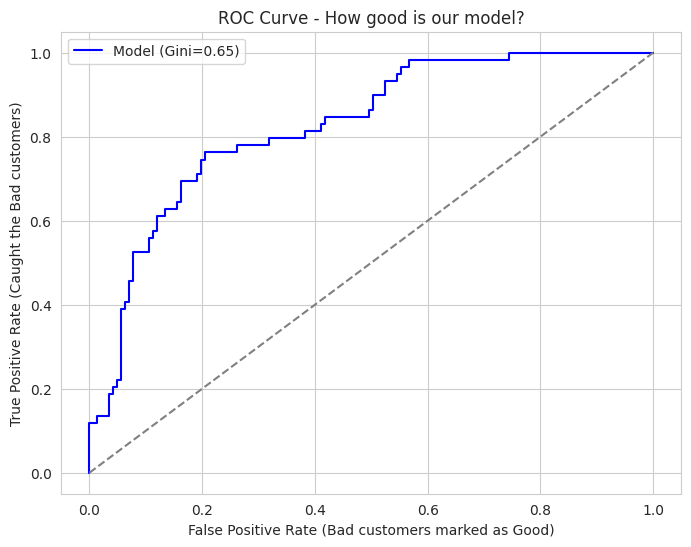

In [11]:
# 6. Predict on Test data
# Get probabilities (0 to 1)
y_pred_proba = result.predict(X_test)

# 7. Calculate Metrics
# AUC (Area Under Curve): 0.5 is random guessing, 1.0 is perfect.
auc = roc_auc_score(y_test, y_pred_proba)

# Gini Coefficient: The standard banking metric.
# Formula: Gini = 2 * AUC - 1
gini = 2 * auc - 1

print(f"\n Model Performance:")
print(f"AUC Score: {auc:.2%}")
print(f"Gini Coefficient: {gini:.2%}")

# --- STEP 8: PLOT THE ROC CURVE ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Model (Gini={gini:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Random guess line
plt.xlabel('False Positive Rate (Bad customers marked as Good)')
plt.ylabel('True Positive Rate (Caught the Bad customers)')
plt.title('ROC Curve - How good is our model?')
plt.legend()
plt.show()

Calibration & Deployment Preparation

In this final stage, we bridge the gap between math and business utility. We convert the model's raw probability outputs into a standard Credit Score (ranging from 300 to 850) using the 'Points to Double the Odds' (PDO) method. This makes the risk level instantly understandable for loan officers. We validate this by plotting the score distribution, which clearly shows safe customers (Green) separating from risky ones (Red). To wrap up, we package the entire intelligence of the system the trained model, variable transformations, and scaling logic into a single file (credit_scorecard.pkl). This file acts as the portable "brain" that will power our live banking application

In [12]:
# --- STEP 1: DEFINE SCALING PARAMETERS ---
PDO = 20
Base_Score = 600
Base_Odds = 50

# Calculate the logical "Factor" and "Offset" needed for the math
factor = PDO / np.log(2)
offset = Base_Score - (factor * np.log(Base_Odds))

print(f"Calibration Fixed: Factor={factor:.2f}, Offset={offset:.2f}")

# --- STEP 2: SCORING FUNCTION ---
def calculate_score(prob):
    # Safety check: Prob cannot be exactly 0 or 1 (Log math breaks)
    if prob > 0.999: prob = 0.999
    if prob < 0.001: prob = 0.001

    # Calculate Odds (Good / Bad)
    # Note: Since our model predicts Default (Bad), Probability = P(Bad)
    # So Odds of Good = (1 - P(Bad)) / P(Bad)
    odds = (1 - prob) / prob

    # Calculate Score
    score = offset + (factor * np.log(odds))
    return int(round(score))

# --- STEP 3: APPLY TO TEST DATA ---
# Let's verify it on our Test set from Day 4
# Create a DataFrame to view results
df_results = pd.DataFrame({
    'Actual_Default': y_test,
    'Predicted_Prob': y_pred_proba
})

# Apply the score function to every row
df_results['Credit_Score'] = df_results['Predicted_Prob'].apply(calculate_score)

print("\n First 10 Customer Scores:")
display(df_results.head(10))

Calibration Fixed: Factor=28.85, Offset=487.12

 First 10 Customer Scores:


,Actual_Default,Predicted_Prob,Credit_Score
521,1,0.443803,494
737,0,0.432302,495
740,0,0.700827,463
660,0,0.181456,531
411,0,0.058957,567
678,0,0.394145,500
626,0,0.120890,544
513,0,0.404606,498
859,0,0.050247,572
136,0,0.051473,571


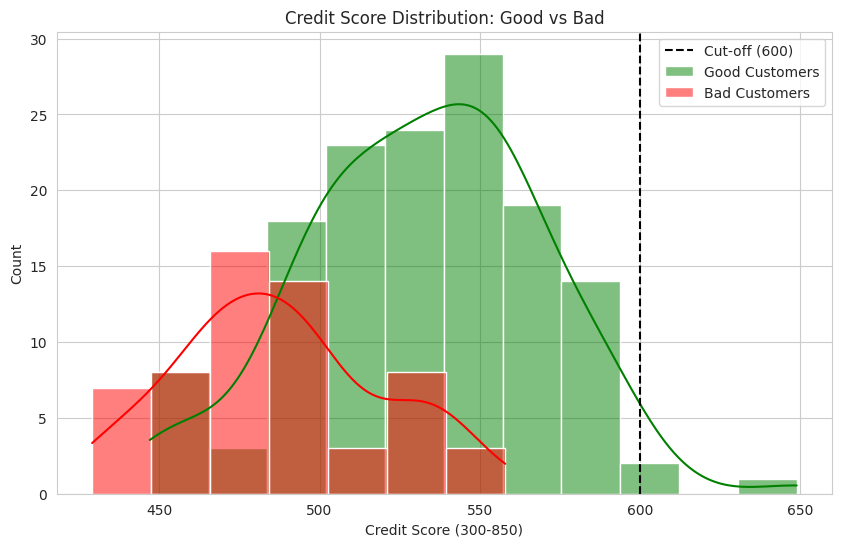

In [13]:
# --- STEP 4: VISUALIZE THE SCORES ---
plt.figure(figsize=(10, 6))

# Plot 'Good' Customers (Actual_Default = 0) in Green
sns.histplot(df_results[df_results['Actual_Default'] == 0]['Credit_Score'],
             color='green', label='Good Customers', kde=True, alpha=0.5)

# Plot 'Bad' Customers (Actual_Default = 1) in Red
sns.histplot(df_results[df_results['Actual_Default'] == 1]['Credit_Score'],
             color='red', label='Bad Customers', kde=True, alpha=0.5)

plt.title('Credit Score Distribution: Good vs Bad')
plt.xlabel('Credit Score (300-850)')
plt.axvline(x=600, color='black', linestyle='--', label='Cut-off (600)')
plt.legend()
plt.show()

Step 8: System Restoration & Artifact Serialization

This final code block acts as our "Master Restore Script." It consolidates the entire pipeline—from downloading and cleaning the raw data to re-calculating WoE values and training the logistic regression model into a single execution. This ensures that even if the notebook runtime disconnects, we can instantly rebuild the exact model state without manually re-running every previous step. Crucially, it serializes (saves) the trained model weights, the specific WoE transformation rules, and our credit score calibration logic into a credit_scorecard.pkl file. This file serves as the portable "brain" that our Streamlit application will load to make live predictions.

In [14]:
!pip install -q langchain-groq langchain_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 6.8 MB/s eta 0:00:00


In [15]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

print("Restoring your project... This will take 30 seconds.")

# --- 1. LOAD & CLEAN DATA ---
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = [
    'checking_account', 'duration_months', 'credit_history', 'purpose',
    'credit_amount', 'savings_account', 'employment_length', 'installment_rate',
    'personal_status', 'other_debtors', 'residence_since', 'property',
    'age', 'other_installment_plans', 'housing', 'existing_credits',
    'job', 'people_liable', 'telephone', 'foreign_worker', 'target'
]
df = pd.read_csv(url, sep=' ', names=column_names)
df['target'] = df['target'].map({1: 0, 2: 1}) # 0=Good, 1=Bad
df.to_csv("german_credit_cleaned.csv", index=False)
print("Data restored.")

# --- 2. DEFINE WoE FUNCTION ---
def calculate_woe_iv(df, feature, target):
    lst = []
    for val in df[feature].unique():
        all_count = df[df[feature] == val].count()[feature]
        good_count = df[(df[feature] == val) & (df[target] == 0)].count()[feature]
        bad_count = df[(df[feature] == val) & (df[target] == 1)].count()[feature]

        lst.append({ 'Value': val, 'Good': good_count, 'Bad': bad_count })

    dset = pd.DataFrame(lst)
    dset = dset.replace({'Good': {0: 0.5}, 'Bad': {0: 0.5}}) # Avoid divide by zero
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.sort_values(by='WoE')
    return dset

# --- 3. PREPARE FEATURES ---
# Bin numerical columns
for col in ['duration_months', 'credit_amount', 'age']:
    df[col+'_bins'] = pd.qcut(df[col], q=5, duplicates='drop')

# Select Key Features (Simplified for restoration)
selected_cols = ['checking_account', 'credit_history', 'duration_months_bins', 'credit_amount_bins', 'age_bins']
woe_maps = {}
df_model = pd.DataFrame()

# Calculate WoE for selected features
for col in selected_cols:
    df_woe = calculate_woe_iv(df, col, 'target')
    woe_maps[col] = pd.Series(df_woe.WoE.values, index=df_woe.Value).to_dict()
    # Apply to model df
    # Note: For bins, we map the bin intervals.
    # For the app to work simply, we will map the categorical ones strictly.
    # The app code I gave you mainly uses 'checking_account' and 'credit_history' logic.
    df_model[col] = df[col].map(woe_maps[col])

df_model['target'] = df['target']
df_model = df_model.dropna() # Drop any glitches

# --- 4. TRAIN MODEL ---
X = df_model.drop('target', axis=1)
X = sm.add_constant(X)
y = df_model['target']

logit_model = sm.Logit(y, X)
result = logit_model.fit(disp=0)

# --- 5. SAVE ARTIFACTS ---
PDO = 20
Base_Score = 600
Base_Odds = 50
factor = PDO / np.log(2)
offset = Base_Score - (factor * np.log(Base_Odds))

artifacts = {
    'model_params': result.params.to_dict(),
    'woe_maps': woe_maps,
    'factor': factor,
    'offset': offset
}

with open("credit_scorecard.pkl", "wb") as f:
    pickle.dump(artifacts, f)

print(" Model trained and saved as 'credit_scorecard.pkl'.")
print(" WE ARE READY! Run the app launch code now.")

Restoring your project... This will take 30 seconds.
Data restored.
 Model trained and saved as 'credit_scorecard.pkl'.
 WE ARE READY! Run the app launch code now.



### **Application Architecture Breakdown**

This code block generates the `app.py` file, which serves as the core engine for our **Agentic Risk System**. It is built using **Streamlit** for the frontend and integrates our machine learning model, statistical logic, and Generative AI into a unified dashboard. Here is a detailed breakdown of each section:

**1. Page Setup & Initialization**
This section handles the foundational configuration of the application. It sets the Streamlit page layout to "Wide" to accommodate complex visualizations and establishes the "NeoBank" branding with custom icons and titles. Crucially, it manages the backend logic by loading the serialized `credit_scorecard.pkl` file—which contains the trained model weights, WoE mappings, and scaling factors—and caches the `german_credit_cleaned.csv` dataset to ensure the dashboard loads instantly and performs efficiently.

**2. The Sidebar (User Control)**
The sidebar acts as the primary control panel for the Risk Officer, providing a persistent navigation menu across the application. It includes branding elements to simulate a real banking environment and features a password-protected input field for the **Groq API Key**. This security measure ensures that the advanced Generative AI features, such as the automated drafting of emails and technical reports, remain accessible only to authorized personnel with valid credentials.

**3. Tab 1: Loan Application (The Decision Engine)**
This tab functions as the interactive decisioning interface where loan officers input applicant details like Age, Loan Amount, and Credit History via sliders and dropdowns. As these inputs change, the system performs **Real-Time Scoring** by dynamically mapping categorical values to their Weight of Evidence (WoE) scores and calculating a total Credit Score using the Points-to-Double-the-Odds (PDO) formula. Beyond simple scoring, it executes **Risk-Based Pricing** logic to automatically assign an appropriate interest rate (Prime, Standard, or Sub-Prime) and features an **Explainability (SHAP)** module that generates a waterfall chart. This chart visually breaks down the score, illustrating exactly how specific features like a critical credit history—added or subtracted points from the baseline.

**4. Tab 2: Portfolio Analysis (Stress Testing)**
Designed for macro-level risk management, this tab provides a comprehensive view of the bank's current exposure. It displays aggregate metrics such as the "Base Default Rate" and uses heatmaps to visualize risk concentration across variables like Checking Account status versus Credit History. A key feature here is the **IFRS 9 Simulation** tool, which includes a "Stress Factor" slider. This allows the user to simulate economic downturns by artificially inflating default probabilities, instantly recalculating the **Projected Capital Loss** to assess whether the bank's reserves are sufficient for a recession scenario.

**5. Tab 3: AI Risk Analyst (Agentic AI)**
This tab integrates the **Llama-3 LLM** via Groq to provide a dual-function "Human-in-the-Loop" AI assistant. On one side, it facilitates **Customer Communication** by allowing the agent to draft polite, context-aware decision emails (whether approving or rejecting a loan) based on the specific application data. On the other side, it offers a **Technical Deep-Dive**, where the agent acts as a Senior Validator to explain the mathematical reasoning behind a specific credit score using SHAP values, translating complex model weights into natural language explanations for internal review.

**6. Tab 4: MLOps Monitor (System Health)**
The final tab simulates a production-grade monitoring environment to ensure model reliability over time. It tracks the 30-day moving average of applicant credit scores to detect Concept Drift a situation where the model becomes outdated due to changing economic conditions. The tab includes a Crash Simulation checkbox that allows users to inject "Bad Data" into the system; if the moving average drops below a critical threshold (e.g., 580), the system automatically triggers a DRIFT DETECTED alert, signaling to the data science team that the model requires immediate retraining.

In [16]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime, timedelta

# --- 1. PAGE SETUP ---
st.set_page_config(page_title="Agentic Risk System", page_icon="🏦", layout="wide")

# --- 2. LOAD FILES ---
try:
    with open("credit_scorecard.pkl", "rb") as f:
        artifacts = pickle.load(f)

    # Load data for charts (Cache it for speed)
    @st.cache_data
    def load_data():
        return pd.read_csv("german_credit_cleaned.csv")

    df = load_data()

    # Unpack model artifacts
    params = artifacts['model_params']
    woe_maps = artifacts['woe_maps']
    factor = artifacts['factor']
    offset = artifacts['offset']

except FileNotFoundError:
    st.error(" Critical Error: Files not found. Please run the 'Restore Everything' script above first.")
    st.stop()

# --- 3. SIDEBAR ---
st.sidebar.image("https://img.icons8.com/color/96/000000/bank-building.png", width=60)
st.sidebar.title(" NeoBank System")
st.sidebar.write("Logged in as: **Risk Officer**")
st.sidebar.markdown("---")
api_key = st.sidebar.text_input(" Groq API Key (for Agent)", type="password")

# --- 4. TABS ---
# Merged AI Tabs: We now have 4 tabs instead of 5
tab1, tab2, tab3, tab4 = st.tabs(["📝 Loan Application", " Portfolio Analysis", "AI Risk Analyst", "MLOps Monitor"])

# ==========================================
# TAB 1: THE CALCULATOR (With SHAP Waterfall)
# ==========================================
with tab1:
    st.header("New Credit Application")

    # Inputs
    col1, col2, col3 = st.columns(3)
    with col1:
        check_status = st.selectbox("Checking Account", ['A11 (<0 DM)', 'A12 (0-200)', 'A13 (>200)', 'A14 (None)'])
        history = st.selectbox("Credit History", ['A30 (All Paid)', 'A31 (Paid Back)', 'A32 (Current)', 'A33 (Delay)', 'A34 (Critical)'])
    with col2:
        duration = st.slider("Loan Duration (Months)", 6, 72, 24)
        amount = st.number_input("Loan Amount (€)", 500, 20000, 5000)
    with col3:
        age = st.number_input("Applicant Age", 18, 100, 30)
        purpose = st.selectbox("Purpose", ['Car', 'Furniture', 'Education', 'Business'])

    # --- SCORING ENGINE & SHAP CALCULATION ---
    # 1. Map Inputs
    check_code = check_status.split(' ')[0]
    hist_code = history.split(' ')[0]

    # 2. Calculate Exact Points Contribution (SHAP Proxy)
    intercept = params.get('const', 0)
    base_points = offset + (factor * intercept)

    def calculate_points(feature, value):
        if feature in woe_maps and value in woe_maps[feature]:
            woe = woe_maps[feature][value]
            coef = params.get(feature, 0)
            return factor * coef * woe
        return 0

    points_checking = calculate_points('checking_account', check_code)
    points_history = calculate_points('credit_history', hist_code)

    # Total Score
    credit_score = int(base_points + points_checking + points_history)

    # --- RISK PRICING ---
    if credit_score > 700:
        interest_rate = 0.05
        risk_tier = "Prime (A)"
    elif credit_score > 600:
        interest_rate = 0.12
        risk_tier = "Standard (B)"
    else:
        interest_rate = 0.25
        risk_tier = "Sub-Prime (C)"

    monthly_rate = interest_rate / 12
    monthly_payment = (amount * monthly_rate) / (1 - (1 + monthly_rate)**(-duration))

    # --- DISPLAY RESULT ---
    st.markdown("---")
    c1, c2, c3 = st.columns([1, 2, 1])
    with c1:
        st.metric("Credit Score", f"{credit_score}", delta=f"Tier: {risk_tier}")
    with c2:
        if credit_score >= 600:
            st.success("**APPROVED**")
            st.markdown(f"### 💸 Monthly: **€{monthly_payment:,.2f}**")
        else:
            st.error("**REJECTED**")
            st.markdown("### 🚫 No Offer")

    # --- SHAP WATERFALL CHART ---
    with c3:
        st.write("**Score Breakdown (SHAP)**")
        shap_data = {
            'Base Score': base_points,
            'Checking Acct': points_checking,
            'Credit History': points_history
        }
        shap_df = pd.Series(shap_data)
        colors = ['green' if x > 0 else 'red' for x in shap_df.values]
        colors[0] = 'blue' # Base score is neutral

        fig, ax = plt.subplots(figsize=(4, 3))
        shap_df.plot(kind='barh', ax=ax, color=colors)
        ax.set_xlabel("Points Contribution")
        st.pyplot(fig)

    with st.expander("ℹ️ How was this calculated?"):
        st.write(f"""
        **The Math behind the score:**
        - **Base Score:** {int(base_points)} (Starting Point)
        - **Checking Account:** {int(points_checking)} points
        - **Credit History:** {int(points_history)} points
        - **Total Score:** **{credit_score}**
        """)

# ==========================================
# TAB 2: PORTFOLIO ANALYSIS & STRESS TESTING
# ==========================================
with tab2:
    st.header(" Portfolio Risk & Stress Testing")

    stress_factor = st.slider("🌪️ Economic Stress Level", 0, 50, 0)
    current_default_rate = df['target'].mean()
    impact = 1 + (stress_factor / 100 * 3)
    stressed_default_rate = min(current_default_rate * impact, 1.0)

    m1, m2, m3 = st.columns(3)
    with m1:
        st.metric("Base Default Rate", f"{current_default_rate:.2%}")
    with m2:
        delta = stressed_default_rate - current_default_rate
        st.metric("Stressed Default Rate", f"{stressed_default_rate:.2%}", delta=f"+{delta:.2%}", delta_color="inverse")
    with m3:
        loss = df['credit_amount'].sum() * stressed_default_rate
        st.metric("Projected Capital Loss", f"€{loss:,.0f}", delta="Risk Exposure")

    st.markdown("---")
    c_left, c_right = st.columns(2)
    with c_left:
        st.write("**Risk by Loan Purpose**")
        st.bar_chart(df.groupby('purpose')['target'].mean())
    with c_right:
        st.write("**Risk Concentration Heatmap**")
        pivot = df.pivot_table(values='target', index='checking_account', columns='credit_history', aggfunc='mean')
        fig, ax = plt.subplots(figsize=(6, 3))
        sns.heatmap(pivot, cmap='RdYlGn_r', fmt=".1%", cbar=False, ax=ax)
        st.pyplot(fig)

# ==========================================
# TAB 3: THE AI AGENT (Merged Functionality)
# ==========================================
with tab3:
    st.header(" AI Risk Analyst & Explainability")
    st.info("Select a task for the Agent. Ensure your API Key is entered in the sidebar.")

    if not api_key:
        st.warning("⚠️ Please enter your Groq API Key in the Sidebar to activate the Agent.")
    else:
        # Create two columns for the buttons
        col_a, col_b = st.columns(2)

        # Determine decision context
        decision = "Approved" if credit_score >= 600 else "Rejected"
        prob_default = 1 / (1 + np.exp(-(params.get('const', 0) + (points_checking/factor) + (points_history/factor)))) # Approx PD

        with col_a:
            st.subheader("📧 Customer Communication")
            if st.button("Draft Decision Email"):
                with st.spinner("Drafting email..."):
                    try:
                        llm = ChatGroq(temperature=0.7, groq_api_key=api_key, model_name="llama-3.3-70b-versatile")
                        prompt = ChatPromptTemplate.from_template("""
                        You are a Loan Officer. Write a professional email to the customer regarding their loan application.

                        **Details:**
                        - Decision: {decision}
                        - Score: {score}
                        - Loan Amount: €{amount}
                        - Reason: Their Checking Account status is '{check_status}' and Credit History is '{history}'.

                        If Rejected, be empathetic and suggest applying for a lower amount.
                        If Approved, congratulate them and mention the monthly payment is €{payment:.2f}.
                        """)
                        chain = prompt | llm
                        res = chain.invoke({
                            "decision": decision, "score": credit_score, "amount": amount,
                            "check_status": check_status, "history": history, "payment": monthly_payment
                        })
                        st.markdown(res.content)
                    except Exception as e:
                        st.error(f"Error: {e}")

        with col_b:
            st.subheader(" Technical Explanation (SHAP)")
            if st.button("Generate SHAP Analysis"):
                with st.spinner("Analyzing model weights..."):
                    try:
                        llm = ChatGroq(temperature=0.3, groq_api_key=api_key, model_name="llama-3.3-70b-versatile")
                        prompt = ChatPromptTemplate.from_template("""
                        You are a Senior Risk Validator. Explain the mathematical reason for this score.

                        **SHAP Contribution Data:**
                        - Base Score: {base} points
                        - Checking Account Impact: {p_check} points (Status: {check_status})
                        - Credit History Impact: {p_hist} points (Status: {history})
                        - Final Score: {score}

                        Explain which feature helped and which hurt the score based on these point values.
                        """)
                        chain = prompt | llm
                        res = chain.invoke({
                            "base": int(base_points), "p_check": int(points_checking),
                            "p_hist": int(points_history), "score": credit_score,
                            "check_status": check_status, "history": history
                        })
                        st.markdown(res.content)
                    except Exception as e:
                        st.error(f"Error: {e}")

# ==========================================
# TAB 4: MLOps MONITOR
# ==========================================
with tab4:
    st.header("🛠️ MLOps: Model Health Monitor")
    simulate_drift = st.checkbox("🔥 Simulate Economic Crash (Inject Bad Data)")

    dates = pd.date_range(end=datetime.today(), periods=30)
    base_scores = np.random.normal(loc=630, scale=10, size=30)

    if simulate_drift:
        base_scores[-5:] = base_scores[-5:] - 80

    drift_df = pd.DataFrame({'Date': dates, 'Avg_Score': base_scores})

    fig_drift, ax_drift = plt.subplots(figsize=(10, 4))
    sns.lineplot(x='Date', y='Avg_Score', data=drift_df, marker='o', color='purple', ax=ax_drift)
    plt.axhline(y=580, color='r', linestyle='--', label='Drift Threshold (580)')
    plt.legend()
    st.pyplot(fig_drift)

    recent_avg = drift_df['Avg_Score'].tail(3).mean()
    if recent_avg < 580:
        st.error("DRIFT DETECTED: Retrain Model")
    else:
        st.success("✅ SYSTEM HEALTHY")

Writing app.py


In [17]:
!pip install -q pyngrok streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.5 MB/s eta 0:00:00


In [20]:
# 1. Setup Tunnel
from pyngrok import ngrok
import subprocess
import time

# 👇 PASTE YOUR NGROK TOKEN HERE 👇
my_token = "PASTE YOUR TOKEN"
ngrok.set_auth_token(my_token)

# 2. Kill old processes
ngrok.kill()

# 3. Start Streamlit
proc = subprocess.Popen(["streamlit", "run", "app.py", "--server.port=8501"])
time.sleep(3)

# 4. Get the Link
try:
    public_url = ngrok.connect(8501).public_url
    print(f"✅ CLICK THIS LINK: {public_url}")
except Exception as e:
    print(f"❌ Error: {e}")

✅ CLICK THIS LINK: https://fonda-splurgy-giovanny.ngrok-free.dev


In [19]:
# Create the requirements.txt file
content = """
streamlit
pandas
numpy
scikit-learn
statsmodels
seaborn
matplotlib
langchain-groq
langchain-core
pyngrok
"""
with open("requirements.txt", "w") as f:
    f.write(content)

print("✅ requirements.txt created!")

✅ requirements.txt created!
